<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing

In [9]:
import numpy as np
import pandas as pd

#loading
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")
CENTURY = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/CENTURY.csv')
CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")
EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")
GILL = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/GILL.csv')

#cleaning
drop_names = ["fontVariant","m_label","orientation","m_top","m_left","originalH","originalW","h","w"]
FONT = [BITSTREAMVERA, CENTURY, CONSOLAS, EBRIMA, GILL]; CL = []
for i in range(5):
  CL.append(FONT[i][(FONT[i]['strength']==0.4) & (FONT[i]['italic']==0)].drop(drop_names,axis=1))

#transforming
def fontToMatrix(font, df):
  for case in range(df.shape[0]):
    font[case] =  np.array(df[df.columns[3:]].iloc[case]).reshape(20,20)

FONT_mat = [] #font as 20x20 matrix
for i in range(5):
  FONT_mat.append(np.empty((CL[i].shape[0],20,20), int))
  fontToMatrix(FONT_mat[i], CL[i])

Examples

Bitstream



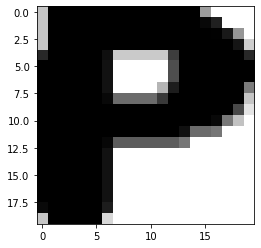

Century



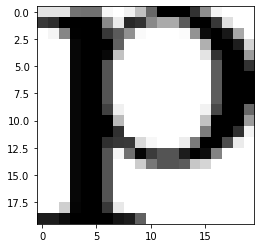

Consolas



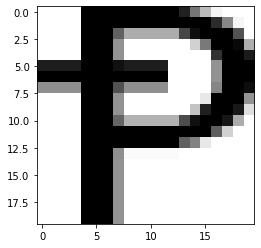

Ebrima



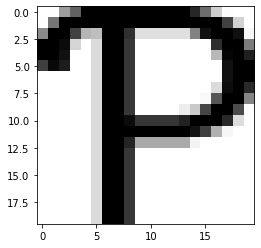

Gill



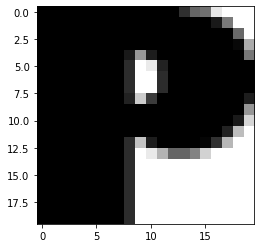

In [10]:
import matplotlib.pyplot as plt

print('Bitstream\n'); plt.imshow(FONT_mat[0][8], cmap=plt.cm.binary); plt.show() 
print('Century\n'); plt.imshow(FONT_mat[1][199], cmap=plt.cm.binary); plt.show() 
print('Consolas\n'); plt.imshow(FONT_mat[2][26], cmap=plt.cm.binary); plt.show() 
print('Ebrima\n'); plt.imshow(FONT_mat[3][1387], cmap=plt.cm.binary); plt.show() 
print('Gill\n'); plt.imshow(FONT_mat[4][243], cmap=plt.cm.binary); plt.show() 

train/test split

In [11]:
from sklearn.model_selection import train_test_split

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CENTURY', 2:'CONSOLAS', 3:'EBRIMA', 4:'GILL'}.get, model.predict(x).argmax(axis = -1)))

dataX = np.concatenate(([FONT_mat[i] for i in range(5)])).reshape(-1,20,20,1)
dataY = np.concatenate(([CL[i]['font'] for i in range(5)]))
train, test = train_test_split(range(dataX.shape[0]), test_size = 0.2, random_state = 0)
x_train = dataX[train]; x_test = dataX[test]
y_train = dataY[train]; y_test = dataY[test]

#CNN

(https://www.tensorflow.org/tutorials/images/cnn)

In [17]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#build (step 3)
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu')) #100 chosen at random
model.add(layers.Dense(5))
model.add(layers.Dense(5, activation='softmax'))
#model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, tf.one_hot(pd.Series(y_train,dtype='category').astype('category').cat.codes,5), epochs=20, batch_size= int(len(train)**0.5),
                    validation_data=(x_test, tf.one_hot(pd.Series(y_test, dtype='category').astype('category').cat.codes,5)))

Epoch 1/20
89/89 [==============================] - 2s 22ms/step - loss: 10.9520 - accuracy: 0.2922 - val_loss: 1.8665 - val_accuracy: 0.4275
Epoch 2/20
89/89 [==============================] - 2s 21ms/step - loss: 1.6405 - accuracy: 0.4734 - val_loss: 1.3887 - val_accuracy: 0.4731
Epoch 3/20
89/89 [==============================] - 2s 21ms/step - loss: 1.2636 - accuracy: 0.5173 - val_loss: 1.2495 - val_accuracy: 0.5417
Epoch 4/20
89/89 [==============================] - 2s 21ms/step - loss: 1.1217 - accuracy: 0.5614 - val_loss: 1.1773 - val_accuracy: 0.5376
Epoch 5/20
89/89 [==============================] - 2s 20ms/step - loss: 1.0396 - accuracy: 0.6051 - val_loss: 1.1029 - val_accuracy: 0.5832
Epoch 6/20
89/89 [==============================] - 2s 21ms/step - loss: 0.9669 - accuracy: 0.6271 - val_loss: 1.0869 - val_accuracy: 0.5842
Epoch 7/20
89/89 [==============================] - 2s 21ms/step - loss: 0.9429 - accuracy: 0.6436 - val_loss: 1.0657 - val_accuracy: 0.6011
Epoch 8/20
8

Performance during learning (currently incorrect for training sets)

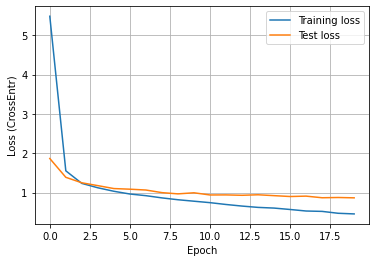

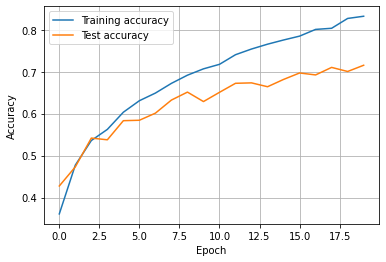

In [18]:
def plotCrssEntr(monitor):
  plt.plot(monitor.model.history.history['loss'], label = 'Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label = 'Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def plotAcc(monitor):
  plt.plot(monitor.model.history.history['accuracy'], label = 'Training accuracy')
  plt.plot(monitor.model.history.history['val_accuracy'], label = 'Test accuracy')
  plt.xlabel('Epoch'); plt.ylabel('Accuracy')
  plt.legend(); plt.grid(True); plt.show()

plotCrssEntr(monitor); plotAcc(monitor)

Conf Matirx

In [19]:
def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

trainConf = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf)

testConf = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf)

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.948802  0.003922  0.040339  0.003695  0.019409
CENTURY             0.005447  0.915033  0.045817  0.043607  0.056377
CONSOLAS            0.019063  0.016993  0.766932  0.109387  0.044362
EBRIMA              0.005447  0.040523  0.087151  0.804139  0.036044
GILL                0.021242  0.023529  0.059761  0.039172  0.843808

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.836207  0.018325  0.050388  0.022293  0.046931
CENTURY             0.012931  0.777487  0.063953  0.060510  0.079422
CONSOLAS            0.060345  0.054974  0.645349  0.210191  0.144404
EBRIMA              0.019397  0.112565  0.143411  0.636943  0.083032
GILL                0.071121  0.036649  0.096899  0.070064  0.646209
